In [1]:
# All the necesssary imports.
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from keras.layers.core import Activation, Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Load in the data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize to [-1, 1]
print(y_train)
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

# For the sake of time don't work with the entire dataset.
x_train = x_train[:20000]
y_train = y_train[:20000]
y_train_cat = to_categorical(y_train, num_classes=20)
y_test_cat = to_categorical(y_test, num_classes=20)
print(y_train)
print (x_train[0].shape)
print(y_train_cat.shape)
print(y_train.shape)
print (y_test_cat.shape)
# Flatten the data.
# x_train = x_train.reshape((-1, 784))
# x_test = x_test.reshape((-1, 784))

[5 0 4 ..., 5 6 8]
[5 0 4 ..., 1 4 2]
(28, 28)
(20000, 20)
(20000,)
(10000, 20)


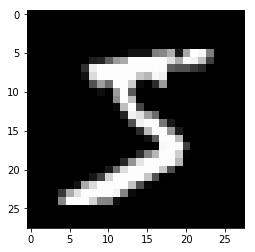

[5 0 4 ..., 1 4 2]


In [3]:
# Plot out a sample image (reshaped to 28 x 28)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.show()
print(y_train)

In [4]:
# How many noise dimensions our generator should take in
NOISE_DIM = 20 # Changed to 10 because of the ten possible digits

# Define the generator here.
# The generator should have the following layers.
# Fully connected from # noise dimensions to 256
# LeakyReLU
# Fully connected from 256 to 512
# LeakyReLU
# Fully connected from 512 to 1024
# LeakyReLU
# Fully connected from 1024 to 784 (28*28)
# tanh (To normalize our output from -1 to 1)

def generator():
    ###################################
    #TODO: Implement
    model = Sequential()
    
    # How to add leaky relu
    #model.add(LeakyReLU())
    model.add(Dense(256, input_shape=(NOISE_DIM,), ))
    model.add(LeakyReLU())
    model.add(Dropout(.3))
    
    model.add(Dense(512))
    model.add(LeakyReLU())
    model.add(Dropout(.3))
    
    model.add(Dense(1024))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Dense(784))
    model.add(Activation('tanh'))
    
    model.add(Reshape((28, 28, -1)))
    return model
    ###################################

In [5]:
#Random number between 0 and top
def rand(top):
    return np.random.randint(low=0, high=top)
    

In [6]:
# Define the discriminator here.
# Should have the following layers
# Fully connected from 784 (28*28) to 1024 0
# LeakyReLU 0
# Dropout with p = 0.3 0
# Fully connected from 1024 to 512 0
# LeakyReLU 0
# Dropout with p = 0.3 0
# Fully connected from 512 to 256 0
# LeakyReLU
# Dropout with p = 0.3
# Fully connected from 256 to 1
# sigmoid (to get our probability)

def discriminator():
    ###################################
    #TODO: Implement    
    
    model = Sequential()
    #model.add(Dense(784), input_dim=784)
    model.add(Conv2D(128, input_shape= (28, 28, 1), kernel_size=3,data_format='channels_last'))
    #kernel_initializer=initializers.RandomNormal(stddev=0.02),
                    
    model.add(LeakyReLU())
    
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=3))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, kernel_size=2))
    model.add(LeakyReLU())
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(1, activation='sigmoid')) 
    
    return model
    ###################################

In [7]:
# Feed the generated image into the discriminator. 
# We’ll use this to train our generator end-to-end later on, 
    # while leaving the discriminator weights untouched
# Remember that we are not updating our discriminator in this step. 
# Hint: we can add existing Sequential() models to new models, just like we can with any other layer.
    # The parameters are then "passed by reference," so that they use the same internal weights.

# Please refer to 
# https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers
# on how to "freeze" or set layers to be untrainable in keras.
# we can call this operation on an entire model.

def combine(generator, discriminator):
    ###################################
    #TODO: Implement
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model
    ###################################

In [8]:
#Make so that model learns how to write individual digits as well (0-9)
def digitRecognizer():
    model = Sequential()
    model.add(Conv2D(input_shape = [28, 28, 1], filters = 128, kernel_size=3, 
                activation='relu', data_format="channels_last"))
    model.add(Conv2D(filters = 128, kernel_size=3,
                activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters = 64, kernel_size=2,
                activation='relu'))
    model.add(Conv2D(filters = 64, kernel_size=2,
                activation='relu'))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(20, activation='softmax')) 
    
    return model

In [9]:
# Compile the discriminator, generator, and full GAN. 
# Probably use Adam optimizer...
optimizer = Adam(lr=0.0002, beta_1=0.5)
loss = 'binary_crossentropy'

#############################################
# TODO: Compile generator and discriminator

# Discriminator
d = discriminator()
d.compile(loss=loss, optimizer=optimizer)

# Generator
g = generator()
g.compile(loss=loss, optimizer=optimizer)

# Full gan
gd = combine(g, d)
gd.compile(loss=loss, optimizer=optimizer)

digit = digitRecognizer()
digit.compile(loss='categorical_crossentropy', optimizer='RMSProp')

print("Discriminator Summary: ")
d.summary()
print("")

print("Generator Sumamry: ")
g.summary()
print("")

print("DigitRecognizer Summary: ")
digit.summary()
gdigit = combine(g, digit)
gdigit.compile(loss=loss, optimizer='RMSProp')
#############################################

Discriminator Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 26, 26, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)    

In [10]:
def get_noise(batch_size, NOISE_DIM):
    noise = np.random.uniform(0, .001, size=(batch_size, NOISE_DIM))
    for i in range(len(noise)):
        #Random number between 0 and 9
        index = rand(9)
        noise[i][index] += .999
    return noise

In [11]:
# Helper function to display sample from the network
def disp_sample(g):
    #Put noise between 0 and .5 so that not very likely to be most digits, with one above this amount
    noise = get_noise(batch_size, NOISE_DIM)    
    generated_images = g.predict(noise, verbose=0)
    
    for pic in range(4):
        for num in range(len(noise[pic])):
            if noise[pic][num] > .6:
                print ("Supposed to be " + str(num))
        #Print what it's 'supposed' to look like
        plt.imshow(generated_images[pic].reshape((28, 28)), cmap=plt.get_cmap('gray'))
        plt.show()

In [12]:
#Function takes noise and returns the y_vals for the generated image (i.e. 10 + whatever their value should be)
def target_y(y_vals):
    copy = y_vals
    for i in range(len(copy)):
        copy[i] += 10
    return to_categorical(copy, num_classes=20)
    

[5 0 4 ..., 1 4 2]
Starting regression...
Epoch #0
Supposed to be 4


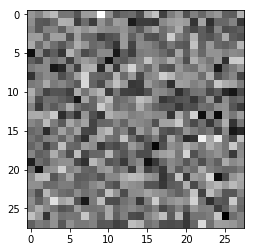

Supposed to be 7


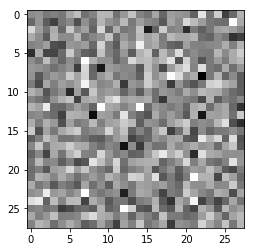

Supposed to be 2


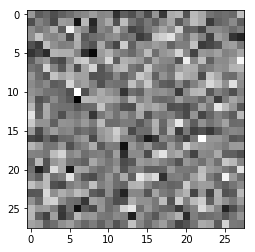

Supposed to be 4


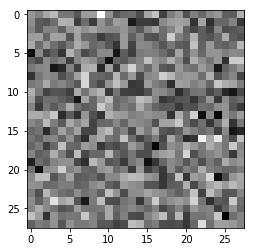

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(0/156) Digit: 2.9970, gdigit: 0.1832
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(1/156) Digit: 4.2258, gdigit: 0.1968
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(2/156) Digit: 2.9213, gdigit: 0.1925
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(3/156) Digit: 2.9384, gdigit: 0.1893
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(4/156) Digit: 2.9258, gdigit: 0.1937
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(5/156) Digit: 2.8155, gdigit: 0.2108
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(6/156) Digit: 2.5234, gdigit: 0.1884
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(7/156) Digit: 2.4504, gdigit: 0.2142
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(8/156) Digit: 2.8008, gdigit: 0.1562
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(9/156) Digit: 2.6453, gdigit: 0.1737
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(10/156) Digit: 2.5466, gdigit: 0.1377
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(11/156) Digit: 2.4456, gdigit: 0.1544
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(12/156) Digit: 2.3442, gdigi

0(106/156) Digit: 2.2396, gdigit: 0.1362
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(107/156) Digit: 1.8647, gdigit: 0.1985
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(108/156) Digit: 1.6312, gdigit: 0.1591
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(109/156) Digit: 1.6759, gdigit: 0.1922
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(110/156) Digit: 1.6475, gdigit: 0.1489
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(111/156) Digit: 1.6940, gdigit: 0.2318
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(112/156) Digit: 1.6736, gdigit: 0.1278
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(113/156) Digit: 1.6686, gdigit: 0.2507
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(114/156) Digit: 1.7736, gdigit: 0.1309
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(115/156) Digit: 1.6713, gdigit: 0.2586
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(116/156) Digit: 1.7259, gdigit: 0.1387
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(117/156) Digit: 1.5785, gdigit: 0.2358
(128, 20)
(128, 20)
(256, 28, 28, 1)
0(118/156) Digit: 1.6828, gdigit: 0.1446
(128, 20)
(128, 20)
(25

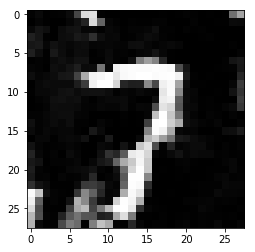

Supposed to be 4


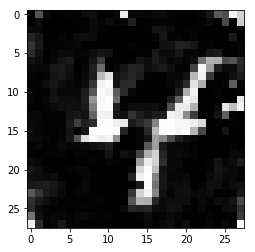

Supposed to be 5


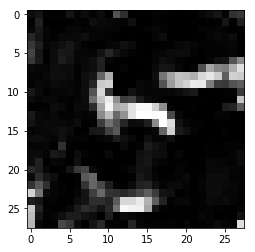

Supposed to be 2


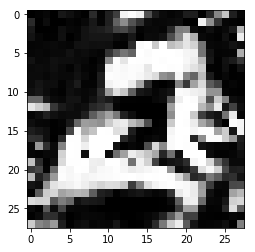

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(0/156) Digit: 1.5880, gdigit: 0.1708
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(1/156) Digit: 1.6874, gdigit: 0.2631
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(2/156) Digit: 1.7042, gdigit: 0.0807
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(3/156) Digit: 2.1007, gdigit: 0.3014
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(4/156) Digit: 2.2566, gdigit: 0.1722
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(5/156) Digit: 1.7591, gdigit: 0.1910
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(6/156) Digit: 1.5978, gdigit: 0.1694
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(7/156) Digit: 1.5786, gdigit: 0.1865
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(8/156) Digit: 1.6807, gdigit: 0.1643
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(9/156) Digit: 1.7705, gdigit: 0.2088
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(10/156) Digit: 1.7200, gdigit: 0.1413
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(11/156) Digit: 1.6904, gdigit: 0.2940
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(12/156) Digit: 1.8822, gdigi

1(106/156) Digit: 1.5672, gdigit: 0.2390
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(107/156) Digit: 1.5336, gdigit: 0.1346
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(108/156) Digit: 1.6569, gdigit: 0.3862
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(109/156) Digit: 2.1305, gdigit: 0.1097
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(110/156) Digit: 1.8627, gdigit: 0.2243
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(111/156) Digit: 1.5836, gdigit: 0.1705
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(112/156) Digit: 1.5647, gdigit: 0.1855
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(113/156) Digit: 1.5515, gdigit: 0.1787
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(114/156) Digit: 1.4982, gdigit: 0.2341
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(115/156) Digit: 1.4723, gdigit: 0.2207
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(116/156) Digit: 1.5474, gdigit: 0.1450
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(117/156) Digit: 1.6901, gdigit: 0.3683
(128, 20)
(128, 20)
(256, 28, 28, 1)
1(118/156) Digit: 2.0212, gdigit: 0.1260
(128, 20)
(128, 20)
(25

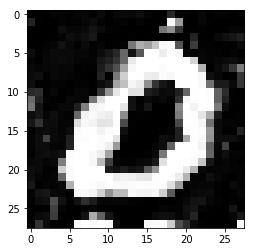

Supposed to be 7


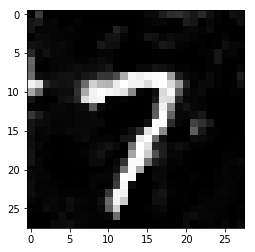

Supposed to be 4


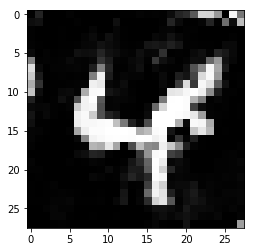

Supposed to be 0


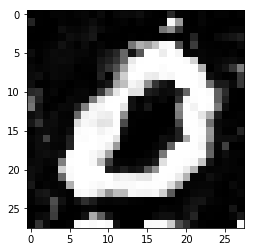

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(0/156) Digit: 1.7990, gdigit: 0.1724
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(1/156) Digit: 1.6138, gdigit: 0.2001
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(2/156) Digit: 1.5711, gdigit: 0.1925
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(3/156) Digit: 1.6669, gdigit: 0.2177
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(4/156) Digit: 1.6595, gdigit: 0.1376
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(5/156) Digit: 1.6955, gdigit: 0.3489
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(6/156) Digit: 1.9648, gdigit: 0.0860
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(7/156) Digit: 2.1469, gdigit: 0.2581
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(8/156) Digit: 1.9056, gdigit: 0.1945
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(9/156) Digit: 1.7668, gdigit: 0.1640
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(10/156) Digit: 1.6458, gdigit: 0.2236
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(11/156) Digit: 1.6310, gdigit: 0.1429
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(12/156) Digit: 1.6557, gdigi

2(106/156) Digit: 1.4996, gdigit: 0.2443
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(107/156) Digit: 1.4708, gdigit: 0.1458
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(108/156) Digit: 1.7070, gdigit: 0.3527
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(109/156) Digit: 2.0557, gdigit: 0.1271
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(110/156) Digit: 1.8304, gdigit: 0.2578
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(111/156) Digit: 1.6159, gdigit: 0.2029
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(112/156) Digit: 1.5197, gdigit: 0.1913
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(113/156) Digit: 1.5432, gdigit: 0.1693
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(114/156) Digit: 1.4661, gdigit: 0.2218
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(115/156) Digit: 1.4445, gdigit: 0.2251
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(116/156) Digit: 1.3767, gdigit: 0.2343
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(117/156) Digit: 1.4002, gdigit: 0.1674
(128, 20)
(128, 20)
(256, 28, 28, 1)
2(118/156) Digit: 1.7119, gdigit: 0.3647
(128, 20)
(128, 20)
(25

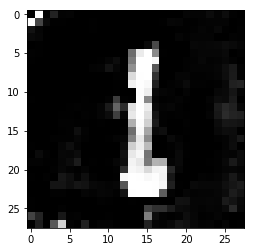

Supposed to be 2


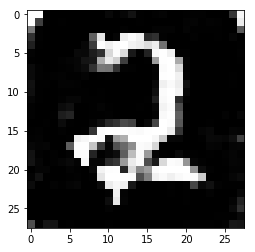

Supposed to be 4


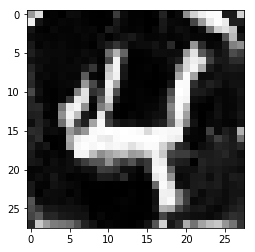

Supposed to be 5


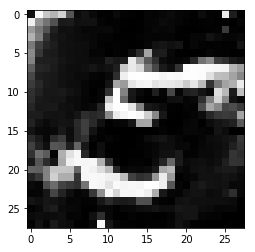

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(0/156) Digit: 1.5255, gdigit: 0.2331
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(1/156) Digit: 1.5878, gdigit: 0.1417
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(2/156) Digit: 1.5849, gdigit: 0.2722
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(3/156) Digit: 1.5605, gdigit: 0.1354
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(4/156) Digit: 1.6330, gdigit: 0.3111
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(5/156) Digit: 1.8502, gdigit: 0.1411
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(6/156) Digit: 1.7249, gdigit: 0.2773
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(7/156) Digit: 1.6495, gdigit: 0.1592
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(8/156) Digit: 1.7137, gdigit: 0.2226
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(9/156) Digit: 1.6615, gdigit: 0.1519
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(10/156) Digit: 1.6244, gdigit: 0.2994
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(11/156) Digit: 1.6864, gdigit: 0.1070
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(12/156) Digit: 1.9909, gdigi

3(106/156) Digit: 1.4903, gdigit: 0.1735
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(107/156) Digit: 1.4752, gdigit: 0.2297
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(108/156) Digit: 1.4404, gdigit: 0.1950
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(109/156) Digit: 1.5069, gdigit: 0.2695
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(110/156) Digit: 1.4744, gdigit: 0.1090
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(111/156) Digit: 1.9674, gdigit: 0.3922
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(112/156) Digit: 2.1759, gdigit: 0.1741
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(113/156) Digit: 1.7359, gdigit: 0.2541
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(114/156) Digit: 1.4763, gdigit: 0.1894
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(115/156) Digit: 1.5186, gdigit: 0.2198
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(116/156) Digit: 1.5490, gdigit: 0.1554
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(117/156) Digit: 1.4961, gdigit: 0.2824
(128, 20)
(128, 20)
(256, 28, 28, 1)
3(118/156) Digit: 1.6764, gdigit: 0.1242
(128, 20)
(128, 20)
(25

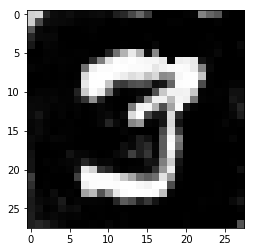

Supposed to be 1


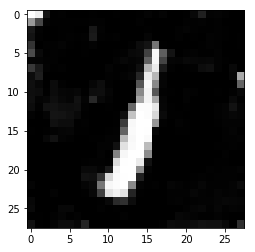

Supposed to be 3


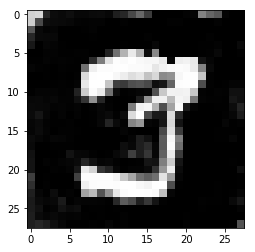

Supposed to be 1


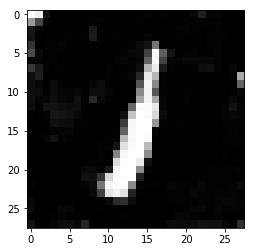

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(0/156) Digit: 1.6104, gdigit: 0.1431
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(1/156) Digit: 1.6757, gdigit: 0.2310
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(2/156) Digit: 1.5511, gdigit: 0.1501
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(3/156) Digit: 1.5684, gdigit: 0.2240
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(4/156) Digit: 1.5724, gdigit: 0.1498
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(5/156) Digit: 1.6357, gdigit: 0.2979
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(6/156) Digit: 1.6436, gdigit: 0.1539
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(7/156) Digit: 1.6145, gdigit: 0.3075
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(8/156) Digit: 1.8028, gdigit: 0.1587
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(9/156) Digit: 1.6836, gdigit: 0.2394
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(10/156) Digit: 1.6210, gdigit: 0.0870
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(11/156) Digit: 2.1036, gdigit: 0.3723
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(12/156) Digit: 1.9506, gdigi

4(106/156) Digit: 1.6419, gdigit: 0.2702
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(107/156) Digit: 1.6465, gdigit: 0.1347
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(108/156) Digit: 1.7455, gdigit: 0.2960
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(109/156) Digit: 1.8635, gdigit: 0.1688
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(110/156) Digit: 1.7686, gdigit: 0.2703
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(111/156) Digit: 1.7435, gdigit: 0.1572
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(112/156) Digit: 1.5913, gdigit: 0.2324
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(113/156) Digit: 1.6180, gdigit: 0.1320
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(114/156) Digit: 1.6147, gdigit: 0.2499
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(115/156) Digit: 1.5784, gdigit: 0.1527
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(116/156) Digit: 1.6749, gdigit: 0.2537
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(117/156) Digit: 1.5864, gdigit: 0.1213
(128, 20)
(128, 20)
(256, 28, 28, 1)
4(118/156) Digit: 1.6846, gdigit: 0.2915
(128, 20)
(128, 20)
(25

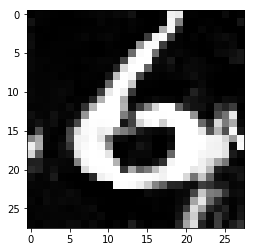

Supposed to be 7


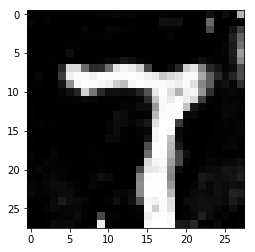

Supposed to be 5


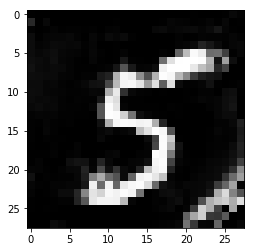

Supposed to be 6


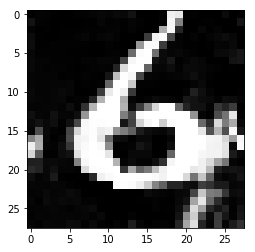

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(0/156) Digit: 1.5554, gdigit: 0.2014
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(1/156) Digit: 1.5606, gdigit: 0.1949
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(2/156) Digit: 1.4687, gdigit: 0.2072
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(3/156) Digit: 1.4962, gdigit: 0.1782
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(4/156) Digit: 1.4503, gdigit: 0.2469
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(5/156) Digit: 1.5243, gdigit: 0.1455
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(6/156) Digit: 1.6126, gdigit: 0.3725
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(7/156) Digit: 1.8930, gdigit: 0.1547
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(8/156) Digit: 1.6246, gdigit: 0.2738
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(9/156) Digit: 1.5760, gdigit: 0.1703
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(10/156) Digit: 1.5609, gdigit: 0.2694
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(11/156) Digit: 1.5203, gdigit: 0.1688
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(12/156) Digit: 1.5831, gdigi

5(106/156) Digit: 1.4812, gdigit: 0.1917
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(107/156) Digit: 1.4858, gdigit: 0.1977
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(108/156) Digit: 1.5917, gdigit: 0.2227
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(109/156) Digit: 1.5751, gdigit: 0.1366
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(110/156) Digit: 1.6483, gdigit: 0.3955
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(111/156) Digit: 2.3302, gdigit: 0.1495
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(112/156) Digit: 1.6517, gdigit: 0.2306
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(113/156) Digit: 1.7030, gdigit: 0.1227
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(114/156) Digit: 1.6679, gdigit: 0.2856
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(115/156) Digit: 1.5324, gdigit: 0.1830
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(116/156) Digit: 1.5264, gdigit: 0.2240
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(117/156) Digit: 1.3804, gdigit: 0.1842
(128, 20)
(128, 20)
(256, 28, 28, 1)
5(118/156) Digit: 1.4282, gdigit: 0.2458
(128, 20)
(128, 20)
(25

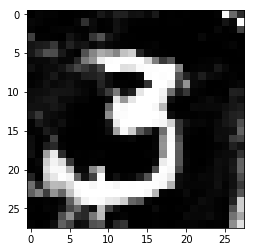

Supposed to be 3


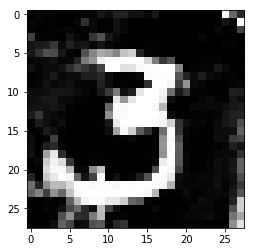

Supposed to be 4


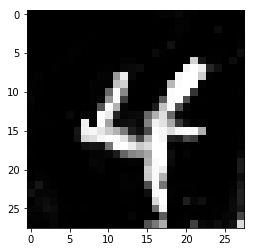

Supposed to be 1


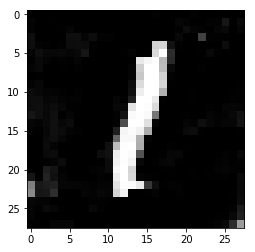

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(0/156) Digit: 1.4590, gdigit: 0.1769
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(1/156) Digit: 1.5208, gdigit: 0.2549
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(2/156) Digit: 1.5401, gdigit: 0.1522
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(3/156) Digit: 1.7315, gdigit: 0.3533
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(4/156) Digit: 1.8796, gdigit: 0.1321
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(5/156) Digit: 1.7329, gdigit: 0.2865
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(6/156) Digit: 1.7763, gdigit: 0.1832
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(7/156) Digit: 1.5347, gdigit: 0.2421
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(8/156) Digit: 1.6232, gdigit: 0.1415
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(9/156) Digit: 1.7232, gdigit: 0.2863
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(10/156) Digit: 1.6540, gdigit: 0.1286
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(11/156) Digit: 1.7211, gdigit: 0.3252
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(12/156) Digit: 1.7357, gdigi

6(106/156) Digit: 2.1017, gdigit: 0.3159
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(107/156) Digit: 2.0751, gdigit: 0.1878
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(108/156) Digit: 1.5022, gdigit: 0.2135
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(109/156) Digit: 1.4275, gdigit: 0.1839
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(110/156) Digit: 1.4454, gdigit: 0.2001
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(111/156) Digit: 1.4268, gdigit: 0.1814
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(112/156) Digit: 1.4583, gdigit: 0.2164
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(113/156) Digit: 1.5222, gdigit: 0.1389
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(114/156) Digit: 1.5976, gdigit: 0.3517
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(115/156) Digit: 1.7910, gdigit: 0.1654
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(116/156) Digit: 1.7925, gdigit: 0.2918
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(117/156) Digit: 1.6261, gdigit: 0.1343
(128, 20)
(128, 20)
(256, 28, 28, 1)
6(118/156) Digit: 1.7004, gdigit: 0.3061
(128, 20)
(128, 20)
(25

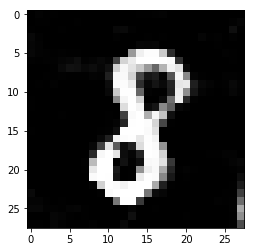

Supposed to be 3


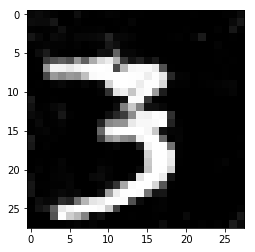

Supposed to be 2


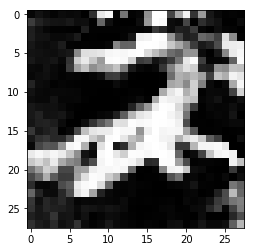

Supposed to be 2


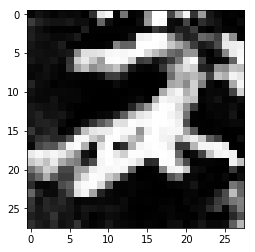

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(0/156) Digit: 1.7287, gdigit: 0.1229
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(1/156) Digit: 1.8142, gdigit: 0.3119
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(2/156) Digit: 1.8007, gdigit: 0.1692
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(3/156) Digit: 1.6962, gdigit: 0.2633
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(4/156) Digit: 1.6480, gdigit: 0.1575
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(5/156) Digit: 1.5684, gdigit: 0.2726
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(6/156) Digit: 1.5170, gdigit: 0.1807
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(7/156) Digit: 1.5212, gdigit: 0.2546
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(8/156) Digit: 1.5596, gdigit: 0.1319
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(9/156) Digit: 1.8665, gdigit: 0.3202
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(10/156) Digit: 2.0997, gdigit: 0.1257
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(11/156) Digit: 1.7757, gdigit: 0.2768
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(12/156) Digit: 1.7282, gdigi

7(106/156) Digit: 1.3812, gdigit: 0.2202
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(107/156) Digit: 1.4360, gdigit: 0.1887
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(108/156) Digit: 1.4671, gdigit: 0.2616
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(109/156) Digit: 1.5517, gdigit: 0.1659
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(110/156) Digit: 1.6285, gdigit: 0.2952
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(111/156) Digit: 1.6188, gdigit: 0.1507
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(112/156) Digit: 1.6434, gdigit: 0.3812
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(113/156) Digit: 1.9190, gdigit: 0.1579
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(114/156) Digit: 1.7694, gdigit: 0.3193
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(115/156) Digit: 1.7198, gdigit: 0.2033
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(116/156) Digit: 1.5825, gdigit: 0.2407
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(117/156) Digit: 1.4891, gdigit: 0.1972
(128, 20)
(128, 20)
(256, 28, 28, 1)
7(118/156) Digit: 1.4595, gdigit: 0.2547
(128, 20)
(128, 20)
(25

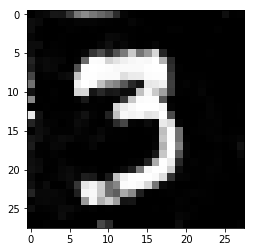

Supposed to be 3


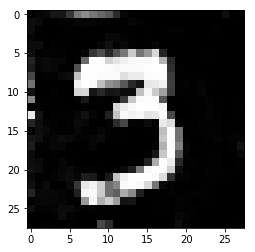

Supposed to be 1


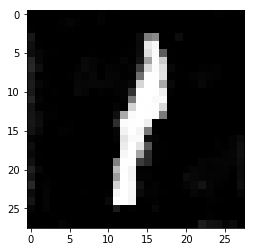

Supposed to be 2


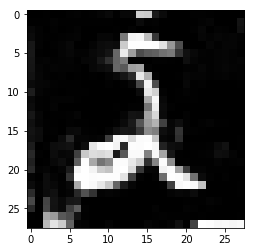

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(0/156) Digit: 1.8017, gdigit: 0.2398
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(1/156) Digit: 1.5569, gdigit: 0.2296
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(2/156) Digit: 1.3887, gdigit: 0.1955
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(3/156) Digit: 1.4573, gdigit: 0.2348
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(4/156) Digit: 1.3941, gdigit: 0.1977
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(5/156) Digit: 1.3684, gdigit: 0.2289
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(6/156) Digit: 1.3903, gdigit: 0.2104
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(7/156) Digit: 1.3947, gdigit: 0.2333
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(8/156) Digit: 1.4869, gdigit: 0.2141
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(9/156) Digit: 1.5457, gdigit: 0.2341
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(10/156) Digit: 1.4636, gdigit: 0.2493
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(11/156) Digit: 1.4418, gdigit: 0.1568
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(12/156) Digit: 1.5923, gdigi

8(106/156) Digit: 1.5787, gdigit: 0.1587
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(107/156) Digit: 1.6084, gdigit: 0.2637
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(108/156) Digit: 1.5119, gdigit: 0.1466
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(109/156) Digit: 1.6581, gdigit: 0.3527
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(110/156) Digit: 1.8646, gdigit: 0.1348
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(111/156) Digit: 1.6909, gdigit: 0.3058
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(112/156) Digit: 1.8327, gdigit: 0.1621
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(113/156) Digit: 1.7505, gdigit: 0.3151
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(114/156) Digit: 1.6489, gdigit: 0.1977
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(115/156) Digit: 1.4978, gdigit: 0.2740
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(116/156) Digit: 1.6792, gdigit: 0.1472
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(117/156) Digit: 1.6020, gdigit: 0.3056
(128, 20)
(128, 20)
(256, 28, 28, 1)
8(118/156) Digit: 1.6333, gdigit: 0.1232
(128, 20)
(128, 20)
(25

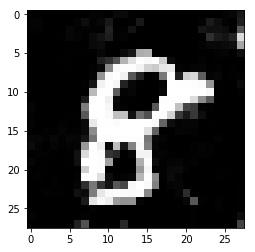

Supposed to be 5


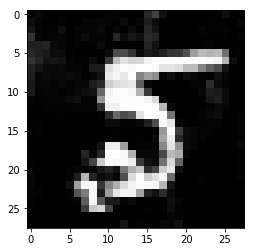

Supposed to be 8


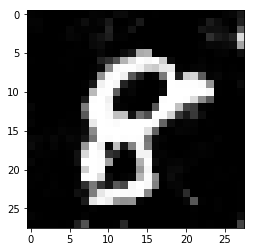

Supposed to be 1


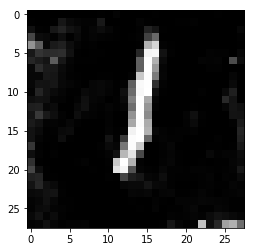

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(0/156) Digit: 1.5151, gdigit: 0.1666
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(1/156) Digit: 1.6237, gdigit: 0.2632
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(2/156) Digit: 1.5366, gdigit: 0.1480
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(3/156) Digit: 1.7903, gdigit: 0.3541
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(4/156) Digit: 1.8852, gdigit: 0.1612
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(5/156) Digit: 1.6328, gdigit: 0.2739
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(6/156) Digit: 1.7477, gdigit: 0.1603
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(7/156) Digit: 1.6104, gdigit: 0.3143
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(8/156) Digit: 1.8279, gdigit: 0.1620
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(9/156) Digit: 1.7255, gdigit: 0.2898
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(10/156) Digit: 1.6007, gdigit: 0.1766
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(11/156) Digit: 1.6404, gdigit: 0.2938
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(12/156) Digit: 1.6688, gdigi

9(106/156) Digit: 2.4177, gdigit: 0.2368
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(107/156) Digit: 1.6305, gdigit: 0.2415
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(108/156) Digit: 1.5270, gdigit: 0.1997
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(109/156) Digit: 1.4974, gdigit: 0.2399
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(110/156) Digit: 1.5821, gdigit: 0.1334
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(111/156) Digit: 1.7944, gdigit: 0.3128
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(112/156) Digit: 1.8151, gdigit: 0.1892
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(113/156) Digit: 1.8196, gdigit: 0.3152
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(114/156) Digit: 1.7797, gdigit: 0.1601
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(115/156) Digit: 1.6686, gdigit: 0.3256
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(116/156) Digit: 1.6612, gdigit: 0.2034
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(117/156) Digit: 1.4947, gdigit: 0.2560
(128, 20)
(128, 20)
(256, 28, 28, 1)
9(118/156) Digit: 1.4403, gdigit: 0.1858
(128, 20)
(128, 20)
(25

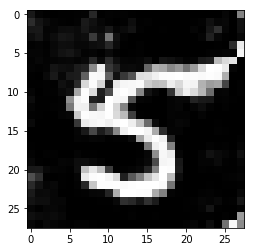

Supposed to be 4


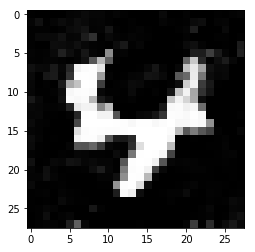

Supposed to be 2


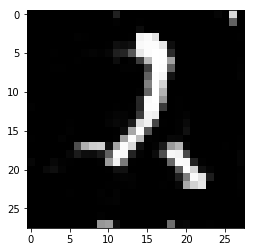

Supposed to be 2


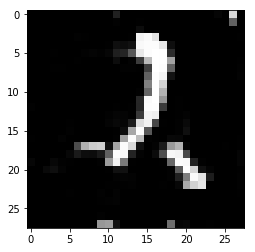

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(0/156) Digit: 1.5920, gdigit: 0.2022
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(1/156) Digit: 1.5387, gdigit: 0.1661
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(2/156) Digit: 1.4327, gdigit: 0.2240
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(3/156) Digit: 1.5014, gdigit: 0.1662
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(4/156) Digit: 1.5200, gdigit: 0.2477
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(5/156) Digit: 1.4439, gdigit: 0.1102
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(6/156) Digit: 1.7641, gdigit: 0.3518
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(7/156) Digit: 2.0811, gdigit: 0.1575
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(8/156) Digit: 1.6922, gdigit: 0.2501
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(9/156) Digit: 1.8192, gdigit: 0.1193
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(10/156) Digit: 1.8142, gdigit: 0.2646
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(11/156) Digit: 1.6337, gdigit: 0.1485
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(12/156) Digit: 

10(105/156) Digit: 1.4654, gdigit: 0.2050
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(106/156) Digit: 1.4400, gdigit: 0.2311
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(107/156) Digit: 1.5082, gdigit: 0.2049
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(108/156) Digit: 1.6563, gdigit: 0.3094
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(109/156) Digit: 1.6550, gdigit: 0.2055
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(110/156) Digit: 1.5065, gdigit: 0.3208
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(111/156) Digit: 1.5952, gdigit: 0.1921
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(112/156) Digit: 1.4755, gdigit: 0.2983
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(113/156) Digit: 1.5551, gdigit: 0.1364
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(114/156) Digit: 1.6075, gdigit: 0.3577
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(115/156) Digit: 1.6574, gdigit: 0.1863
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(116/156) Digit: 1.6210, gdigit: 0.3279
(128, 20)
(128, 20)
(256, 28, 28, 1)
10(117/156) Digit: 1.4479, gdigit: 0.1944
(128, 20)


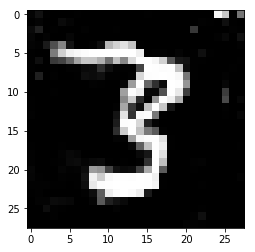

Supposed to be 5


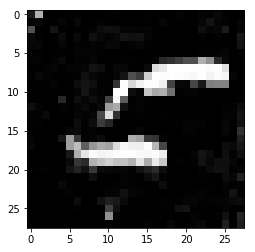

Supposed to be 2


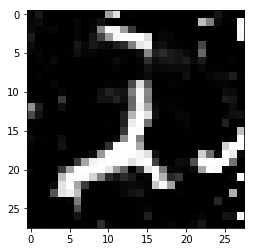

Supposed to be 4


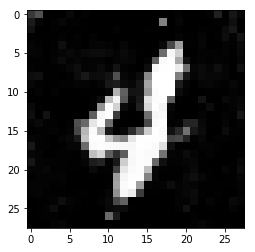

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(0/156) Digit: 1.5300, gdigit: 0.2119
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(1/156) Digit: 1.5377, gdigit: 0.1999
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(2/156) Digit: 1.4511, gdigit: 0.2382
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(3/156) Digit: 1.6036, gdigit: 0.3238
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(4/156) Digit: 1.6838, gdigit: 0.1176
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(5/156) Digit: 1.8957, gdigit: 0.3886
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(6/156) Digit: 2.2551, gdigit: 0.2284
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(7/156) Digit: 1.6130, gdigit: 0.2826
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(8/156) Digit: 1.6542, gdigit: 0.1831
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(9/156) Digit: 1.6571, gdigit: 0.2301
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(10/156) Digit: 1.5856, gdigit: 0.1595
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(11/156) Digit: 1.6065, gdigit: 0.2953
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(12/156) Digit: 

11(105/156) Digit: 1.5530, gdigit: 0.1735
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(106/156) Digit: 1.6445, gdigit: 0.3281
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(107/156) Digit: 1.7302, gdigit: 0.1732
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(108/156) Digit: 1.7701, gdigit: 0.3399
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(109/156) Digit: 1.7058, gdigit: 0.1815
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(110/156) Digit: 1.5825, gdigit: 0.3123
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(111/156) Digit: 1.5454, gdigit: 0.2112
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(112/156) Digit: 1.4719, gdigit: 0.2356
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(113/156) Digit: 1.4433, gdigit: 0.1970
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(114/156) Digit: 1.4289, gdigit: 0.3108
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(115/156) Digit: 1.4573, gdigit: 0.1778
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(116/156) Digit: 1.6281, gdigit: 0.3663
(128, 20)
(128, 20)
(256, 28, 28, 1)
11(117/156) Digit: 1.6093, gdigit: 0.1463
(128, 20)


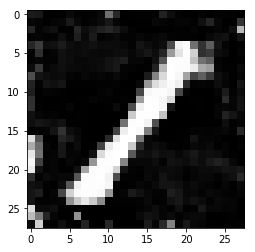

Supposed to be 1


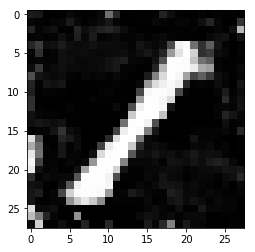

Supposed to be 0


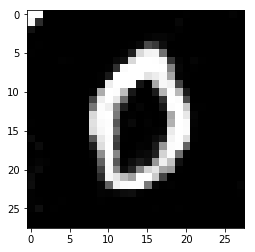

Supposed to be 7


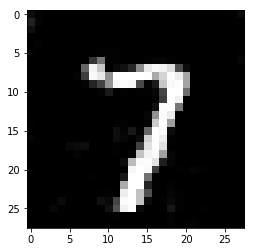

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(0/156) Digit: 1.6432, gdigit: 0.1805
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(1/156) Digit: 1.4834, gdigit: 0.2263
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(2/156) Digit: 1.4620, gdigit: 0.1747
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(3/156) Digit: 1.5647, gdigit: 0.2539
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(4/156) Digit: 1.6304, gdigit: 0.1643
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(5/156) Digit: 1.6384, gdigit: 0.2833
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(6/156) Digit: 1.6974, gdigit: 0.1586
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(7/156) Digit: 1.5540, gdigit: 0.2677
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(8/156) Digit: 1.5251, gdigit: 0.1626
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(9/156) Digit: 1.7646, gdigit: 0.3242
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(10/156) Digit: 1.5736, gdigit: 0.1593
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(11/156) Digit: 1.8107, gdigit: 0.3757
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(12/156) Digit: 

12(105/156) Digit: 1.5948, gdigit: 0.2567
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(106/156) Digit: 1.5916, gdigit: 0.1307
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(107/156) Digit: 1.6120, gdigit: 0.3127
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(108/156) Digit: 1.8040, gdigit: 0.1589
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(109/156) Digit: 1.6482, gdigit: 0.2660
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(110/156) Digit: 1.8122, gdigit: 0.1057
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(111/156) Digit: 1.9133, gdigit: 0.3161
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(112/156) Digit: 1.8517, gdigit: 0.1713
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(113/156) Digit: 1.6314, gdigit: 0.2607
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(114/156) Digit: 1.5736, gdigit: 0.1748
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(115/156) Digit: 1.4977, gdigit: 0.2628
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(116/156) Digit: 1.7787, gdigit: 0.1323
(128, 20)
(128, 20)
(256, 28, 28, 1)
12(117/156) Digit: 1.7549, gdigit: 0.2988
(128, 20)


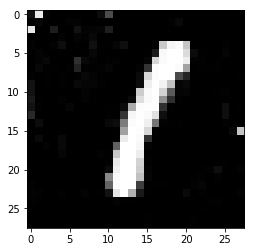

Supposed to be 1


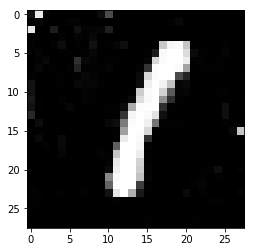

Supposed to be 7


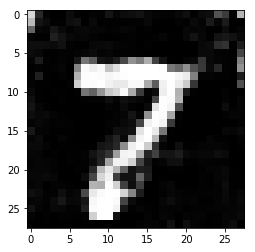

Supposed to be 5


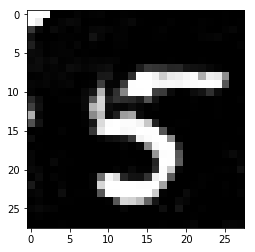

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(0/156) Digit: 1.6415, gdigit: 0.2943
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(1/156) Digit: 1.5153, gdigit: 0.1975
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(2/156) Digit: 1.5282, gdigit: 0.3095
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(3/156) Digit: 1.7135, gdigit: 0.1528
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(4/156) Digit: 1.5250, gdigit: 0.2925
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(5/156) Digit: 1.5061, gdigit: 0.1678
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(6/156) Digit: 1.6004, gdigit: 0.3018
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(7/156) Digit: 1.5752, gdigit: 0.1946
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(8/156) Digit: 1.5591, gdigit: 0.2751
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(9/156) Digit: 1.5143, gdigit: 0.1422
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(10/156) Digit: 2.0194, gdigit: 0.4035
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(11/156) Digit: 2.1843, gdigit: 0.1342
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(12/156) Digit: 

13(105/156) Digit: 1.6051, gdigit: 0.1537
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(106/156) Digit: 1.5940, gdigit: 0.3025
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(107/156) Digit: 1.6988, gdigit: 0.1273
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(108/156) Digit: 1.8549, gdigit: 0.3462
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(109/156) Digit: 1.9230, gdigit: 0.2039
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(110/156) Digit: 1.5177, gdigit: 0.2323
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(111/156) Digit: 1.4299, gdigit: 0.2184
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(112/156) Digit: 1.4896, gdigit: 0.2175
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(113/156) Digit: 1.4636, gdigit: 0.2185
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(114/156) Digit: 1.4996, gdigit: 0.2676
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(115/156) Digit: 1.4667, gdigit: 0.2591
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(116/156) Digit: 1.6190, gdigit: 0.1203
(128, 20)
(128, 20)
(256, 28, 28, 1)
13(117/156) Digit: 1.7800, gdigit: 0.4405
(128, 20)


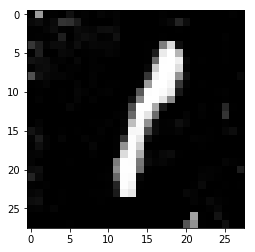

Supposed to be 7


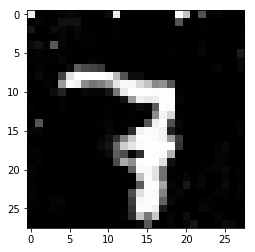

Supposed to be 0


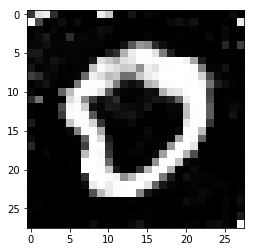

Supposed to be 1


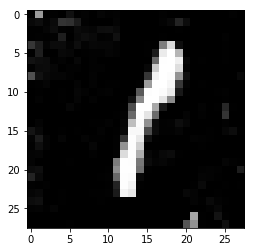

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(0/156) Digit: 1.7427, gdigit: 0.1727
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(1/156) Digit: 1.5848, gdigit: 0.2732
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(2/156) Digit: 1.5115, gdigit: 0.1713
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(3/156) Digit: 1.6844, gdigit: 0.2997
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(4/156) Digit: 1.6084, gdigit: 0.1721
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(5/156) Digit: 1.5303, gdigit: 0.3001
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(6/156) Digit: 1.5582, gdigit: 0.1807
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(7/156) Digit: 1.4422, gdigit: 0.3085
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(8/156) Digit: 1.6051, gdigit: 0.1593
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(9/156) Digit: 1.5466, gdigit: 0.3564
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(10/156) Digit: 1.5490, gdigit: 0.1800
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(11/156) Digit: 1.8317, gdigit: 0.3784
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(12/156) Digit: 

14(105/156) Digit: 1.6907, gdigit: 0.1660
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(106/156) Digit: 1.5433, gdigit: 0.2452
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(107/156) Digit: 1.6095, gdigit: 0.1405
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(108/156) Digit: 1.5519, gdigit: 0.2969
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(109/156) Digit: 1.5925, gdigit: 0.1709
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(110/156) Digit: 1.5404, gdigit: 0.2806
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(111/156) Digit: 1.6182, gdigit: 0.1718
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(112/156) Digit: 1.5406, gdigit: 0.2565
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(113/156) Digit: 1.5129, gdigit: 0.1507
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(114/156) Digit: 1.5802, gdigit: 0.2838
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(115/156) Digit: 1.4942, gdigit: 0.1925
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(116/156) Digit: 1.6613, gdigit: 0.2982
(128, 20)
(128, 20)
(256, 28, 28, 1)
14(117/156) Digit: 1.4977, gdigit: 0.1990
(128, 20)


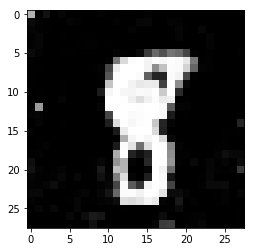

Supposed to be 2


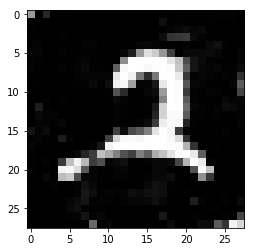

Supposed to be 4


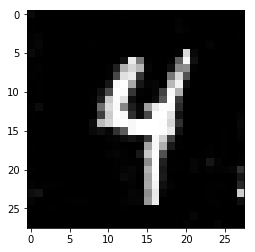

Supposed to be 2


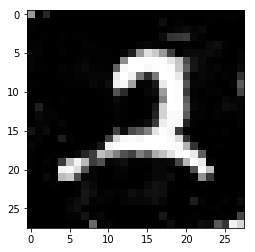

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(0/156) Digit: 1.5138, gdigit: 0.1623
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(1/156) Digit: 1.5876, gdigit: 0.2579
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(2/156) Digit: 1.6321, gdigit: 0.1368
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(3/156) Digit: 1.7096, gdigit: 0.2934
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(4/156) Digit: 1.6451, gdigit: 0.1803
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(5/156) Digit: 1.5466, gdigit: 0.2776
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(6/156) Digit: 1.6509, gdigit: 0.1755
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(7/156) Digit: 1.5363, gdigit: 0.3005
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(8/156) Digit: 1.6820, gdigit: 0.1585
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(9/156) Digit: 1.5982, gdigit: 0.2738
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(10/156) Digit: 1.5909, gdigit: 0.1660
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(11/156) Digit: 1.7082, gdigit: 0.3131
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(12/156) Digit: 

15(105/156) Digit: 1.9717, gdigit: 0.3679
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(106/156) Digit: 2.1596, gdigit: 0.2039
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(107/156) Digit: 1.7527, gdigit: 0.2806
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(108/156) Digit: 1.6835, gdigit: 0.1875
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(109/156) Digit: 1.5213, gdigit: 0.2503
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(110/156) Digit: 1.6726, gdigit: 0.1795
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(111/156) Digit: 1.5921, gdigit: 0.2682
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(112/156) Digit: 1.6124, gdigit: 0.1334
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(113/156) Digit: 1.8910, gdigit: 0.3371
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(114/156) Digit: 1.9268, gdigit: 0.1678
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(115/156) Digit: 1.5040, gdigit: 0.2581
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(116/156) Digit: 1.6444, gdigit: 0.1562
(128, 20)
(128, 20)
(256, 28, 28, 1)
15(117/156) Digit: 1.5696, gdigit: 0.2390
(128, 20)


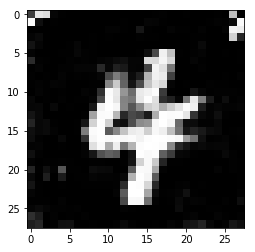

Supposed to be 8


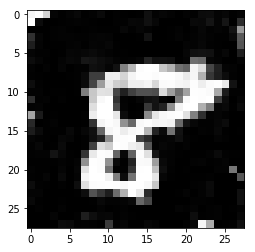

Supposed to be 3


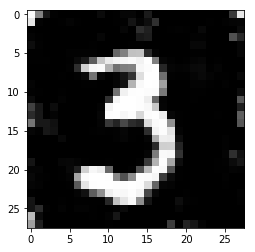

Supposed to be 8


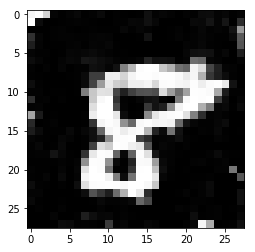

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(0/156) Digit: 1.5783, gdigit: 0.1859
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(1/156) Digit: 1.5602, gdigit: 0.2418
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(2/156) Digit: 1.4251, gdigit: 0.1658
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(3/156) Digit: 1.5401, gdigit: 0.2703
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(4/156) Digit: 1.5983, gdigit: 0.1442
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(5/156) Digit: 1.6611, gdigit: 0.3281
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(6/156) Digit: 1.9548, gdigit: 0.1826
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(7/156) Digit: 1.5690, gdigit: 0.2503
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(8/156) Digit: 1.6630, gdigit: 0.1587
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(9/156) Digit: 1.7881, gdigit: 0.2219
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(10/156) Digit: 1.6808, gdigit: 0.2786
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(11/156) Digit: 1.6433, gdigit: 0.1501
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(12/156) Digit: 

16(105/156) Digit: 1.8692, gdigit: 0.1550
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(106/156) Digit: 1.6942, gdigit: 0.2611
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(107/156) Digit: 1.7537, gdigit: 0.1446
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(108/156) Digit: 1.6784, gdigit: 0.3025
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(109/156) Digit: 1.7432, gdigit: 0.1784
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(110/156) Digit: 1.5406, gdigit: 0.2363
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(111/156) Digit: 1.5319, gdigit: 0.1730
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(112/156) Digit: 1.5702, gdigit: 0.2823
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(113/156) Digit: 1.6068, gdigit: 0.1178
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(114/156) Digit: 1.9150, gdigit: 0.3718
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(115/156) Digit: 2.1622, gdigit: 0.2118
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(116/156) Digit: 1.5797, gdigit: 0.2101
(128, 20)
(128, 20)
(256, 28, 28, 1)
16(117/156) Digit: 1.4546, gdigit: 0.2137
(128, 20)


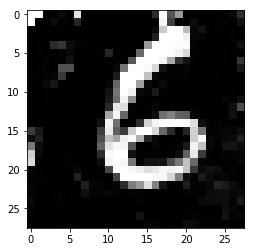

Supposed to be 6


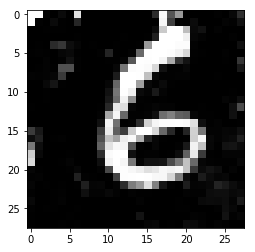

Supposed to be 3


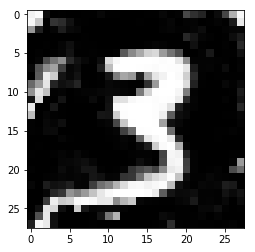

Supposed to be 6


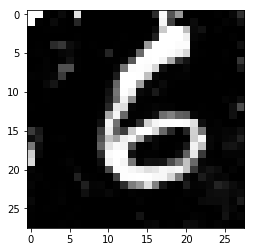

Number batches 156
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(0/156) Digit: 1.6133, gdigit: 0.2716
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(1/156) Digit: 1.6673, gdigit: 0.1359
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(2/156) Digit: 1.8572, gdigit: 0.3202
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(3/156) Digit: 1.7716, gdigit: 0.1965
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(4/156) Digit: 1.5613, gdigit: 0.2576
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(5/156) Digit: 1.4373, gdigit: 0.1734
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(6/156) Digit: 1.4428, gdigit: 0.3046
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(7/156) Digit: 1.5685, gdigit: 0.1571
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(8/156) Digit: 1.7956, gdigit: 0.3539
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(9/156) Digit: 1.8810, gdigit: 0.1585
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(10/156) Digit: 2.2229, gdigit: 0.3587
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(11/156) Digit: 2.0167, gdigit: 0.2246
(128, 20)
(128, 20)
(256, 28, 28, 1)
17(12/156) Digit: 

KeyboardInterrupt: 

In [13]:
# Keep this. 
print(y_train)
batch_size = 128
print("Starting regression...")
target_y = target_y(y_train)
for epoch in range(100): #100 epochs
    print('Epoch #%d' % epoch)
    
    # Generate 6 images and display them.
    disp_sample(g)
    
    num_batches = int(x_train.shape[0] / batch_size)
    print('Number batches %i' % num_batches)
    for i in range(num_batches):
        #######################################################
        #TODO: Complete a training iteration
        # Generate noise.
        noise = get_noise(batch_size, NOISE_DIM)

        # Generate images from the noise using the generator.
        generated_images = g.predict(noise, verbose=0)
        
        # Grab the image batch for this iteration. 
        real_images = x_train[i * batch_size: (i+1) * batch_size]
        real_images = real_images.reshape((-1, 28, 28, 1))
        y_vals = y_train_cat[i * batch_size : (i+1) * batch_size]
        y_target = target_y[i * batch_size : (i+1) * batch_size]
        
        # Train the discriminator using the generated images and the real images.
        # Contains the real and fake images. real then fake
        
        X = np.concatenate([generated_images, real_images])
            
        # Labels if the sample is real (1) or not real (0). 
        print(y_target.shape)
        print(y_vals.shape)
        
        y = np.concatenate([y_target, y_vals])
        
        print(X.shape)
        # Remember that the discriminator has to have d.trainable = True!
        d.trainable = True
        digit.trainable = True 
        #d_loss = d.train_on_batch(X, y)
        
        #Train the digit recognizer with real_images
        digit_loss = digit.train_on_batch(X, y)

        # Generate more noise to feed into the full gan network to train the generative portion. 
        noise = get_noise(batch_size, NOISE_DIM)
        
        d.trainable = False
        digit.trainable = False
        
        # Get the g_loss (fill in the ... part between the parantheses)
        #g_loss = gd.train_on_batch(noise, np.ones(noise.shape[0]))

        # Try to get the generator to generate images similar to what the seed should be
        gdigit_loss = gdigit.train_on_batch(noise, noise) 
        
        print('%i(%i/%i) Digit: %.4f, gdigit: %.4f' % (
            epoch, i, num_batches, digit_loss, gdigit_loss))
        
        #######################################################

#########################################################################################
# Why is my generative loss oscillating???   
# Don't worry this is normal as the generator is oscillating between possible solutions
#########################################################################################
        